In [ ]:
"""def intersect_trop_lines(assumptions, first,second):
    a = first[0]
    b = first[1]
    c = second[0]
    d = second[1]
    #anchored at (c,d)
    if a>c and b>d and a>b: #1
        return [c+b,d+b]
    if a>c and b>d and a<b: #2
        return [c+a,d+a]
    if a>c and b>d and a==b:
        return [c+b-d,b]
    if a<c and b>d: #3
        return [a,d]
    if a<c and b<d and a<b: #4
        return [a+d-b,d]
    if a<c and b<d and a>b: #5
        return [c,b+c-a]
    if a<c and b<d and a==b:
        return [c,b+c-a]
    if a>c and d>b: #6
        return [c,b]
    #anchored at (a,b)
    if c>a and d>b and c>d: #1
        return [a+d,b+d]
    if c>a and d>b and c<d: #2
        return [a+c,b+c]
    if c>a and d>b and c==d:
        return [a+d-b,d]
    if c<a and d>b: #3
        return [c,b]
    if c<a and d<b and c<d: #4
        return [c+b-d,b]
    if c<a and d<b and c>d: #5
        return [a,d+a-c]
    if c<a and d<b and c==d:
        return [a,d+a-c]
    if c>a and b>d: #6
        return [a,d]
    
    
def polytron(assumptions, vertices):
    pseudovertices = copy(vertices)
    edges = []
    for pair in Subsets(range(len(vertices)),2):
        if intersect_trop_lines(assumptions, vertices[pair[0]],vertices[pair[1]]):
            pseudovertices.append(intersect_trop_lines(vertices[pair[0]],vertices[pair[1]]))
            index = len(pseudovertices)-1
            edges.append([pair[0],index])
            edges.append([pair[1],index])
        else:
            edges.append(list(pair))
    return {'pseudo': pseudovertices, 'edges': edges, 'vertices': vertices}


def tangent_cone(polytron, vertex_index):
    
    def primitive_vector_in_edge_direction(direction):
        x = direction[0]
        y = direction[1]
        if x==0 and y>0:
            primitive = [ 0, 1]
        elif x==0 and y<0:
            primitive = [ 0,-1]
        elif x>0 and y>0:
            primitive = [ 1, 1]
        elif x>0 and y==0:
            primitive = [ 1, 0]
        elif x<0 and y==0:
            primitive = [-1, 0]
        elif x<0 and y<0:
            primitive = [-1,-1]
        else:
            print 'cannot find primitive vector in direction ('+str(x)+' , '+str(y)+')'
        return primitive
    
    ##compute the generating function of the tangent cone at the given vertex
    vertex = polytron['pseudo'][vertex_index]
    
    
    #find neighbours of vertex
    incident_edges_index = [edge for edge in polytron["edges"] if vertex_index in edge]
    neighbours_index = []
    for edge_index in incident_edges_index:
        for index in edge_index:
            if index==vertex_index:
                continue
            else:
                neighbours_index.append(index)    
    neighbours = [ polytron['pseudo'][index] for index in neighbours_index ]
    
    #compute edge-directions
    edge_directions = [ [neighbour[0]-vertex[0],neighbour[1]-vertex[1]] for neighbour in neighbours ]
    
    primitives=[]
    #find primitive vector in edge-direction
    for direction in edge_directions:
        primitives.append(primitive_vector_in_edge_direction(direction))
    
    
    t1, t2, n = var('t1, t2, n')
    return ( t1^(n*vertex[0])* t2^(n*vertex[1]) )  / ( (1 - t1^primitives[0][0] * t2^primitives[0][1]) * (1 - t1^primitives[1][0] * t2^primitives[1][1])  )

def gen_fct(polytron):
    return sum([tangent_cone(polytron,vertex_index) for vertex_index in range(len(polytron["pseudo"]))])

def ehrhart(polytron,evaluation):
    solutions = [gen_fct(polytron)(a=evaluation[0],b=evaluation[1]).factor()(n=k).factor()(t1=1,t2=1) for k in range(1,4)]
    mat = matrix([ [1,1,1],
                   [4,2,1],
                   [9,3,1] ])
    coeffs = mat.solve_right(vector(solutions))
    t = var('t')
    return sum(coeffs[i]*t^(2-i) for i in range(3))
        
"""

In [6]:
forget()
a,b,c,d,e,f = var('a,b,c,d,e,f')

We identify symbolic inequalities by the respective vector, 
e.g. we identify $a - c > 0$ with [0, 1, 0,-1, 0, 0, 0].
The feasible region for a list of assumption is then (the interior of) a polehedral cone $P$ which is defined by
the huperplanes orthogonal to these vectors. If we want to test if another symbolic inequality is valid, 
we can consider the intersection of the Halfspace $H$ orthogonal to the respective inequality and $P$.
If both the assumptions and the inequality in question are strict, then it is valid iff $\text{int} P\subseteq\text{int}H$,

In [7]:
def symbols_to_vector(symbolic_expression):
    symbols_vec = [0,a,b,c,d,e,f]
    string = str(symbolic_expression)
    vec = [0,0,0,0,0,0,0]
    sign = 1
    if string == "0":
        return vector(vec)
    for letter in string:
        if letter in [" "]:
            continue
        elif letter in ["+"]:
            sign = 1
        elif letter in ["-"]:
            sign = -1
        elif var(letter) in symbols_vec:
            index = symbols_vec.index(var(letter))
            vec[index] = 1*sign
    return vector(vec)

class expression:
    
    def __init__(self, coordinates, assumptions):
        self.assumptions = assumptions
        self.coordinates = vector(coordinates)
        
    def is_valid_strict(self):
        #checks if a strict inequality (question) is satified under the assumptions of other strict inequalities
        #this is not satisfied if intP interected with H_c is nonempty
        P = Polyhedron(ieqs = self.assumptions)
        #complement of halfspace defined by strict inequality in question
        H_c = Polyhedron(ieqs = [[-i for i in self.coordinates]]) 
        if len(H_c.intersection(P).vertices())==0:
            return true
        else:
            for F in P.faces(5):
                if H_c.intersection(F.as_polyhedron()) == H_c.intersection(P):
                    return true
        return false
    
    def is_valid_nonstrict(self):
        #checks if a non-strict inequality (question) is satified under the assumptions of other strict inequalities
        #this is satisfied if intP is contained in H. H is closed, so this is equivalent to P contianed in H
        P = Polyhedron(ieqs = self.assumptions)
        H = Polyhedron(ieqs = [self.coordinates]) 
        if H.intersection(P)==P:
            return true
        else:     
            return false

    def  __gt__(self, other):
        #definition of >
        #return self.is_valid_strict(assumptions, self.coordinates - other.coordinates)
        return expression(coordinates = self.coordinates - other.coordinates, assumptions = self.assumptions).is_valid_strict()
    
    def __lt__(self,other):
        #definition of <
        return expression(coordinates = other.coordinates - self.coordinates, assumptions = self.assumptions).is_valid_strict()
    
    def __eq__(self, other):
        #definition of ==
        if expression(coordinates = self.coordinates - other.coordinates, assumptions = self.assumptions).is_valid_nonstrict() and expression(coordinates = other.coordinates - self.coordinates, assumptions = self.assumptions).is_valid_nonstrict(): 
            return true
        else:
            return false
    
    def __le__(self, other):
        #definition of <=
        return (self<other or self==other)
    
    def __ge__(self, other):
        #definition of >=
        return (self>other or self==other)
    
    def __add__(self,other):
        #definition of +
        return expression(coordinates = self.coordinates + other.coordinates, assumptions = self.assumptions)
    
    def is_comparable_to(self, other):
        if self>= other or self <= other:
            return true
        else:
            return false
        
    def as_symbols(self):
        symbols_vec = vector([0,a,b,c,d,e,f])
        return symbols_vec.dot_product(vector(self.coordinates))
    


def minimum(expr1, expr2):
    if expr1 <= expr2:
        return expr1
    elif expr2 <= expr1:
        return expr2
    else:
        print("cannot decide minimum of "+str(ieq1)+" and "+str(ieq2)+" under assumptions "+str(assumptions))

def intersect_trop_lines(assumptions, first,second):
    #translate symbolic expressions into vectors
    a_ex = expression(assumptions = assumptions, coordinates = symbols_to_vector(first[0]))
    b_ex = expression(assumptions = assumptions, coordinates = symbols_to_vector(first[1]))
    c_ex = expression(assumptions = assumptions, coordinates = symbols_to_vector(second[0]))
    d_ex = expression(assumptions = assumptions, coordinates = symbols_to_vector(second[1]))
    res = []
    #anchored at (c,d)
    if a_ex>c_ex and b_ex>d_ex and a_ex>b_ex: #1
        res =  [c_ex+b_ex,d_ex+b_ex]
    if a_ex>c_ex and b_ex>d_ex and b_ex>a_ex: #2
        res =  [c_ex+a_ex,d_ex+a_ex]
    if a_ex>c_ex and b_ex>d_ex and a_ex==b_ex:
        res =  [c_ex+b_ex-d_ex,b_ex]
    if a_ex<c_ex and b_ex>d_ex: #3
        res =  [a,d]
    if a_ex<c_ex and b_ex<d_ex and a_ex<b_ex: #4
        res =  [a_ex+d_ex-b_ex,d_ex]
    if a_ex<c_ex and b_ex<d_ex and a_ex>b_ex: #5
        res =  [c_ex,b_ex+c_ex-a_ex]
    if a_ex<c_ex and b_ex<d_ex and a_ex==b_ex:
        res =  [c_ex,b_ex+c_ex-a_ex]
    if a_ex>c_ex and d_ex>b_ex: #6
        res =  [c_ex,b_ex]
    #anchored at (a,b)
    if c_ex>a_ex and d_ex>b_ex and c_ex>d_ex: #1
        res = [a_ex+d_ex,b_ex+d_ex]
    if c_ex>a_ex and d_ex>b_ex and c_ex<d_ex: #2
        res = [a_ex+c_ex,b_ex+c_ex]
    if c_ex>a_ex and d_ex>b_ex and c_ex==d_ex:
        res = [a_ex+d_ex-b_ex,d_ex]
    if c_ex<a_ex and d_ex>b_ex: #3
        res = [c_ex,b_ex]
    if c_ex<a_ex and d_ex<b_ex and c_ex<d_ex: #4
        res = [c_ex+b_ex-d_ex,b_ex]
    if c_ex<a_ex and d_ex<b_ex and c_ex>d_ex: #5
        res = [a_ex,d_ex+a_ex-c_ex]
    if c_ex<a_ex and d_ex<b_ex and c_ex==d_ex:
        res = [a_ex,d_ex+a_ex-c_ex]
    if c_ex>a_ex and b_ex>d_ex: #6
        res = [a_ex,d_ex]
        
    if len(res):
        return [el.as_symbols() for el in res]
    
    
class polytron:
    def __init__(self, assumptions, vertices):
        self.assumptions = assumptions
        self.vertices = vertices
        self.pseudovertices = self.get_pseudo_and_edges(assumptions, vertices)[0]
        self.edges = self.get_pseudo_and_edges(assumptions, vertices)[1]
        
    def get_pseudo_and_edges(self, assumptions, vertices):
        pseudovertices = copy(vertices)
        edges = []
        for pair in Subsets(range(len(vertices)),2):
            if intersect_trop_lines(assumptions, vertices[pair[0]],vertices[pair[1]]):
                pseudovertices.append(intersect_trop_lines(assumptions, vertices[pair[0]],vertices[pair[1]]))
                index = len(pseudovertices)-1
                edges.append([pair[0],index])
                edges.append([pair[1],index])
            else:
                edges.append(list(pair))
        return [pseudovertices, edges]


def tangent_cone(polytron, vertex_index):
    
    def primitive_vector_in_edge_direction(assumptions, direction):
        x = expression(assumptions = assumptions, coordinates = symbols_to_vector(direction[0]))
        y = expression(assumptions = assumptions, coordinates = symbols_to_vector(direction[1]))
        x_negative = expression(assumptions = assumptions, coordinates = [-i for i in x.coordinates])
        y_negative = expression(assumptions = assumptions, coordinates = [-i for i in y.coordinates])
        zero = expression(assumptions = assumptions, coordinates = [0,0,0,0,0,0,0])
        
        if x==zero and y>zero:
            primitive = [ 0, 1]
        elif x==zero and y<zero:
            primitive = [ 0,-1]
        elif x>zero and y>zero:
            primitive = [ 1, 1]
        elif x>zero and y==zero:
            primitive = [ 1, 0]
        elif x<zero and y==zero:
            primitive = [-1, 0]
        elif x<zero and y<zero:
            primitive = [-1,-1]
        else:
            print 'cannot find primitive vector in direction ('+str(x.coordinates)+' , '+str(y.coordinates)+') under assumptions '+str(x.assumptions)
        return primitive
    
    ##compute the generating function of the tangent cone at the given vertex
    vertex = polytron.pseudovertices[vertex_index]
    
    
    #find neighbours of vertex
    incident_edges_index = [edge for edge in polytron.edges if vertex_index in edge]
    neighbours_index = []
    for edge_index in incident_edges_index:
        for index in edge_index:
            if index==vertex_index:
                continue
            else:
                neighbours_index.append(index)    
    neighbours = [ polytron.pseudovertices[index] for index in neighbours_index ]
    
    #compute edge-directions
    edge_directions = [ [neighbour[0]-vertex[0],neighbour[1]-vertex[1]] for neighbour in neighbours ]
    
    primitives=[]
    #find primitive vector in edge-direction
    for direction in edge_directions:
        primitives.append(primitive_vector_in_edge_direction(polytron.assumptions, direction))
    
    
    t1, t2, n = var('t1, t2, n')
    return ( t1^(n*vertex[0])* t2^(n*vertex[1]) )  / ( (1 - t1^primitives[0][0] * t2^primitives[0][1]) * (1 - t1^primitives[1][0] * t2^primitives[1][1])  )


def gen_fct(polytron):
    return sum([tangent_cone(polytron,vertex_index) for vertex_index in range(len(polytron.pseudovertices))])


Instead of symbolic expressions, we work with the class ``expression``. An ``expression`` consists two things: <br/>
1. The ``coordinates`` is a $0/1$-vector, that corresponds to a symbolic expression. <br/>
2. The ``assumptions`` is a list of assumption, also corresponding to symbolic axressions. <br/>
The expression ``e1`` below corrsponds to the symbolic expression $a>0$ under the assumptions $a>0, a+b>0$, the expression ``e2`` corresponds to the symbolic expression $b$ under the same assumption, and ``zero`` corresponds to $0$. We can now test, if $a>0$ is valid under these assumptions.

In [29]:
e1 = expression(coordinates = [0,1,0,0,0,0,0], assumptions = [[0,1,0,0,0,0,0],[0,1,1,0,0,0,0]])
e2 = expression(coordinates = [0,0,1,0,0,0,0], assumptions = [[0,1,0,0,0,0,0],[0,1,1,0,0,0,0]])
zero = expression(coordinates = [0,0,0,0,0,0,0], assumptions = [[0,1,0,0,0,0,0],[0,1,1,0,0,0,0]])
print e1.as_symbols()
print e2.as_symbols()
print zero.as_symbols()
print h.is_valid_strict()

a
b
0
True


If both expressions have the same asumptions, then we can add them up.

In [30]:
g = e1+e2
print g.as_symbols()
print g.coordinates

a + b
(0, 1, 1, 0, 0, 0, 0)


We can try to compare them:

In [31]:
print e1.is_comparable_to(e2)
print zero.is_comparable_to(g)

False
True


If they are comparable, we can find the minimum:

In [32]:
print e3 < g
print minimum(e3,g).as_symbols()

True
0


Making the Polyhedral Subdivision of $\mathbb R^d$  for 6 variables

The Setup: 

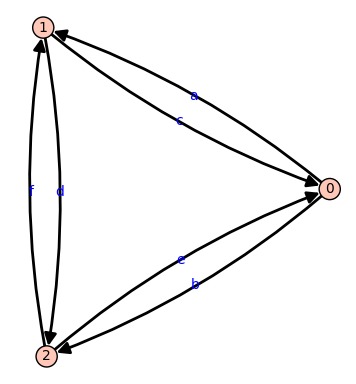

In [33]:

D = matrix([[0,a,b],[c,0,d],[e,f,0]])
DG = DiGraph(D,weighted = True)
DG.show(edge_labels = True)

Here is the Kleene star of D:
D_Star = $
\begin{pmatrix}
min(0,a+c,b+e) & min(a,a,b+f)   & min(b,a+d,b) \\
min(c,c,d+e)   & min(a+c,0,d+f) & min(c+b,d,d) \\
min(e,f+c,e)   & min(a+e,f,f)   & min(e+b,d+f,0)
\end{pmatrix}$

In [34]:
#(1,1)
H1  = Polyhedron(eqns=[[0,1,0,1,0,0,0]],ieqs=[[0,-1,1,-1,0,1,0]])
H2  = Polyhedron(eqns=[[0,0,1,0,0,1,0]],ieqs=[[0,1,-1,1,0,-1,0]])
#(1,2)
H3  = Polyhedron(ieqs=[[0,-1,1,0,0,0,1]])
#(1,3)
H4  = Polyhedron(ieqs=[[0,1,-1,0,1,0,0]])
#(2,1)
H5  = Polyhedron(ieqs=[[0,0,0,-1,1,1,0]])
#(2,2)
H6  = Polyhedron(eqns=[[0,1,0,1,0,0,0]],ieqs=[[0,0,0,0,1,0,1]])
H7  = Polyhedron(eqns=[[0,0,0,0,1,0,1]],ieqs=[[0,1,0,1,0,0,0]])
#(2,3)
H8  = Polyhedron(ieqs=[[0,0,1,1,-1,0,0]])
#(3,1)
H9  = Polyhedron(ieqs=[[0,0,0,1,0,-1,1]])
#(3,2)
H10 = Polyhedron(ieqs=[[0,1,0,0,0,1,-1]])
#(3,3)
H11 = Polyhedron(eqns=[[0,0,1,0,0,1,0]],ieqs=[[0,0,0,0,1,0,1]])
H12 = Polyhedron(eqns=[[0,0,0,0,1,0,1]],ieqs=[[0,0,1,0,0,1,0]])

Redoing the Hyperplanes as regions

In [35]:
#(1,1)
R1   = Polyhedron(ieqs = [[0,-1,1,-1,0,1,0],[0,-1,0,-1,0,0,0]])
R2   = Polyhedron(ieqs = [[0,1,0,1,0,0,0],[0,0,1,0,0,1,0]])
R3   = Polyhedron(ieqs = [[0,0,-1,0,0,-1,0],[0,1,-1,1,0,-1,0]])
F11  = [R1,R2,R3]
#(1,2)
R4   = Polyhedron(ieqs = [[0,-1,1,0,0,0,1]])
R5   = Polyhedron(ieqs = [[0,1,-1,0,0,0,-1]])
F12  = [R4,R5]
#(1,3)
R6   = Polyhedron(ieqs = [[0,1,-1,0,1,0,0]])
R7   = Polyhedron(ieqs = [[0,-1,1,0,-1,0,0]])
F13  = [R6,R7]
#(2,1)
R8   = Polyhedron(ieqs = [[0,0,0,-1,1,1,0]])
R9   = Polyhedron(ieqs = [[0,0,0,1,-1,-1,0]])
F21  = [R8,R9]
#(2,2)
R10  = Polyhedron(ieqs = [[0,-1,0,-1,1,0,1],[0,-1,0,-1,0,0,0]])
R11  = Polyhedron(ieqs = [[0,0,0,0,1,0,1],[0,1,0,1,0,0,0]])
R12  = Polyhedron(ieqs = [[0,0,0,0,-1,0,-1],[0,1,0,1,-1,0,-1]])
F22  = [R10,R11,R12]
#(2,3)
R13  = Polyhedron(ieqs = [[0,0,1,1,-1,0,0]])
R14  = Polyhedron(ieqs = [[0,0,-1,-1,1,0,0]])
F23  = [R13,R14]
#(3,1)
R15  = Polyhedron(ieqs = [[0,0,0,1,0,-1,1]])
R16  = Polyhedron(ieqs = [[0,0,0,-1,0,1,-1]])
F31  = [R15,R16]
#(3,2)
R17  = Polyhedron(ieqs = [[0,1,0,0,0,1,-1]])
R18  = Polyhedron(ieqs = [[0,-1,0,0,0,-1,1]])
F32  = [R17,R18]
#(3,3)
R19  = Polyhedron(ieqs = [[0,0,-1,0,1,-1,1],[0,0,-1,0,0,-1,0]])
R20  = Polyhedron(ieqs = [[0,0,1,0,0,1,0],[0,0,0,0,1,0,1]])
R21  = Polyhedron(ieqs = [[0,0,1,0,-1,1,-1],[0,0,0,0,-1,0,-1]])
F33  = [R19,R20,R21]

Find the feasible, full dimensional regions:

In [36]:
def regions_of_complex(polyhedral_complex):
    r"""
    Returns the feasible regions of the ``polyhedral_complex``.
    Follows the method of regions in the hyperplane arrangements.
    
    INPUT: 
    
    - ``polyhedral_complex`` -- list. A list of polyhedron objects
    
    OUTPUT:
    
    A tuple of regions.
    """
    R = polyhedral_complex[0][0].base_ring()
    universe = Polyhedron(eqns = [[0] + [0]*6],base_ring = R)
    regions = [universe]
    for fan in polyhedral_complex:
        subdivided = []
        for region in regions:
            for cone in fan:
                part = region.intersection(cone)
                if part.dim()==6:
                    subdivided.append(part)
        regions = subdivided
    return tuple(regions)

Test it on the fans

In [37]:
six_variables_complex = [F11,F12,F13,F21,F22,F23,F31,F32,F33]
regions = regions_of_complex(six_variables_complex)

In [38]:
len(regions)

117

Discard the infeasible regions

In [39]:
def feasible_regions(initial_regions):
    r"""
    From the regions of a polyhedral complex, return the feasible regions.
    
    INPUT:
    
    -  ``initial_regions`` -- tuple of polyhedron objects. 
    
    OUTPUT:
    
    tuple of polyhedron objects representiing the feasible regions.
    """

    final_regions = list(initial_regions)
    for region in initial_regions:
        ass = region.inequalities_list()
        q1 = expression(coordinates = [0,-1, 0,-1, 0, 0, 0], assumptions = ass)
        q2 = expression(coordinates = [0, 0,-1, 0, 0,-1, 0], assumptions = ass)
        q3 = expression(coordinates = [0, 0, 0, 0,-1, 0,-1], assumptions = ass)
        if q1.is_valid_strict() or q2.is_valid_strict() or q3.is_valid_strict():
            final_regions.remove(region)
    return final_regions

In [40]:
feas_regs = feasible_regions(regions)

In [41]:
len(feas_regs)

18

In [42]:
first_region= regions[0]
first_region.inequalities_list()

[[0, 1, -1, 0, 1, 0, 0],
 [0, -1, 1, -1, 0, 1, 0],
 [0, 0, -1, 0, 0, -1, 0],
 [0, 0, 0, 1, 0, -1, 1]]

Try to get the Ehrhart polynomial for ``first_region``
These inequalities imply the following kleene star:
D_star_one = 
$\begin{pmatrix}
a+c & a & b \\
c & a+c & c+b \\
e  & a + e & b+e
\end{pmatrix}$

In [43]:
feas_regs[0].inequalities_list()

[[0, -1, 1, 0, 0, 0, 1],
 [0, 0, 0, -1, 1, 1, 0],
 [0, 1, 0, 0, 0, 1, -1],
 [0, 0, 0, 1, 0, -1, 1],
 [0, 1, -1, 0, 1, 0, 0],
 [0, 0, 1, 1, -1, 0, 0]]

In [44]:
def tropical_vertices_from_region(region):
    r"""
    Return the symbolic tropical vertices corresponding to 
    a certain region. 
    
    INPUT:
    
    - ``region`` -- a polyhedron object. 
    
    OUTPUT:
    
    A list of the tropical vertices (already in the plane). 
    """

    ass = region.inequalities_list()
    zero = expression(assumptions = ass, coordinates = [0, 0, 0, 0, 0, 0, 0])
    a_ex = expression(assumptions = ass, coordinates = [0, 1, 0, 0, 0, 0, 0])
    b_ex = expression(assumptions = ass, coordinates = [0, 0, 1, 0, 0, 0, 0])
    c_ex = expression(assumptions = ass, coordinates = [0, 0, 0, 1, 0, 0, 0])
    d_ex = expression(assumptions = ass, coordinates = [0, 0, 0, 0, 1, 0, 0])
    e_ex = expression(assumptions = ass, coordinates = [0, 0, 0, 0, 0, 1, 0])
    f_ex = expression(assumptions = ass, coordinates = [0, 0, 0, 0, 0, 0, 1])
    K = [ [zero,                    minimum(a_ex,b_ex+f_ex), minimum(a_ex+d_ex,b_ex)],
          [minimum(c_ex,d_ex+e_ex), zero,                    minimum(c_ex+b_ex,d_ex)],
          [minimum(f_ex+c_ex,e_ex), minimum(a_ex+e_ex,f_ex), zero                   ]]
    symbols_vec = vector([0,a,b,c,d,e,f])
    Kleene = []
    for row in K:
        Kleene.append([ symbols_vec.dot_product(entry.coordinates) for entry in row ])
    Kleene = matrix(Kleene)
    #subtract the first entry
    L = list()
    for i in range(len(Kleene.rows())):
        new_row = list()
        j = Kleene.row(i)[0]
        for k in range(1,len(Kleene.row(i))):
            new_row.append(Kleene.row(i)[k] - j)
        L.append(new_row)
    return L

In [45]:
verts = tropical_vertices_from_region(feas_regs[0])
ass = feas_regs[0].inequalities_list()
poly = polytron(ass, verts)


In [46]:
poly.pseudovertices

[[a, b], [-c, -c + d], [-e + f, -e], [-c, -e]]

In [47]:
generating_f = gen_fct(poly).factor()

In [48]:
print generating_f

(t1^(a*n + c*n + e*n + 3)*t2^(b*n + c*n + e*n + 3) - t1^(a*n + c*n + e*n + 2)*t2^(b*n + c*n + e*n + 3) - t1^(a*n + c*n + e*n + 3)*t2^(b*n + c*n + e*n + 2) + t1^(a*n + c*n + e*n + 2)*t2^(b*n + c*n + e*n + 2) - t1^(c*n + f*n + 2)*t2^(c*n + 2) + t1^(e*n + 2)*t2^(c*n + 2) + t1^(c*n + f*n + 2)*t2^(c*n + 1) + t1^(c*n + f*n + 1)*t2^(c*n + 1) - 2*t1^(e*n + 1)*t2^(c*n + 1) - t1^(c*n + f*n + 1)*t2^(c*n) + t1^(e*n)*t2^(c*n) - t1^(e*n + 2)*t2^(d*n + e*n + 2) + t1^(e*n + 1)*t2^(d*n + e*n + 2) + t1^(e*n + 1)*t2^(d*n + e*n + 1) - t1^(e*n)*t2^(d*n + e*n + 1))*t1^(-c*n - e*n)*t2^(-c*n - e*n)/((t1*t2 - 1)^2*(t1 - 1)*(t2 - 1))


Try to compute the generating function for all feasible regions. This works for all but region 12 and 16:

In [49]:
count = -1
generating_fcts = []
for region in feas_regs:
    verts = tropical_vertices_from_region(region)
    ass = region.inequalities_list()
    poly = polytron(ass, verts)
    count += 1
    try:
        generating_f = gen_fct(poly).factor()
        generating_fcts.append(generating_f)
    except:
        print 'impossible to compute generating function for region '+str(count)
        continue
    

cannot find primitive vector in direction ((0, -1, 0, 0, -1, -1, 0) , (0, -1, 0, 0, -1, -1, 0)) under assumptions [[0, -1, 0, 0, 0, -1, 1], [0, -1, 1, 0, -1, 0, 0], [0, 0, 0, 0, 1, 0, 1], [0, 0, 0, 1, -1, -1, 0], [0, 0, 1, 0, 0, 1, 0], [0, 1, 0, 1, 0, 0, 0]]
impossible to compute generating function for region 12
cannot find primitive vector in direction ((0, 0, -1, -1, 0, 0, -1) , (0, 0, 0, 0, 0, 0, 0)) under assumptions [[0, 0, -1, -1, 1, 0, 0], [0, 0, 0, -1, 0, 1, -1], [0, 0, 0, 0, 1, 0, 1], [0, 0, 1, 0, 0, 1, 0], [0, 1, -1, 0, 0, 0, -1], [0, 1, 0, 1, 0, 0, 0]]
impossible to compute generating function for region 16


Replace all variables by $(1-t)$ and apply l'hopital in order to evaluate the generating function at $(1,\dots,1)$:

In [50]:
def lhopital(generating_f):
    #substitute all variables by (1-t)
    t = var('t')
    for j in range(1,3):
         generating_f = generating_f.subs({var('t'+str(j)):1-t})
        #generating_f = generating_f.subs({var('t'+str(j)):1-j*t})
    
    #l'hopital
    p = generating_f.numerator()
    q = generating_f.denominator()
    alpha = 0
    p_deriv= p
    q_deriv = q
    while true:
        p_deriv = p_deriv.derivative(t)
        q_deriv = q_deriv.derivative(t)
        alpha += 1
        if not (p_deriv(t=0)==0 or q_deriv(t=0)==0):
            break
    return p_deriv(t=0)/q_deriv(t=0)

Evaluate the generating functions of all regions but 12 and 16 at $(1,\dots,1)$:

In [51]:
multivariate_ehrhart = []
for generating_f in generating_fcts:
    multivariate_ehrhart.append(lhopital(generating_f).simplify_full())

In [52]:
multivariate_ehrhart

[1/8*(a^2 + 2*a*b + b^2 - 4*c^2 + 8*c*d - 2*d^2 + 8*c*e - 4*e^2 + 8*e*f - 2*f^2)*n^2 + 1/8*(7*a + 7*b + 4*c - 4*d + 4*e - 4*f)*n + 5/4,
 -1/4*(a^2 - 2*a*b - b^2 + 2*(a - b)*c + 2*c^2 - 2*c*d + d^2 - 4*(a + c)*e)*n^2 + 1/4*(a + 5*b + 2*c - d + 4*e)*n + 1,
 1/8*(a^2 + 2*a*b + b^2 + 2*(a + b)*c + c^2 + 4*c*d - 2*d^2 + 4*c*f + 2*f^2)*n^2 + 1/8*(7*a + 7*b + 11*c - 4*d)*n + 5/4,
 1/4*(a^2 + 2*a*b - b^2 + 4*b*c + 2*(a - b + 2*c)*e - 2*e^2 + 2*e*f - f^2)*n^2 + 1/4*(5*a + b + 4*c + 2*e - f)*n + 1,
 (a*b + b*c + (a + c)*e)*n^2 + (a + b + c + e)*n + 1,
 1/4*(a^2 + 2*a*b - b^2 + 2*(a + b)*c + 2*c^2 + 2*c*f + f^2)*n^2 + 1/4*(5*a + b + 6*c + f)*n + 1,
 1/8*(a^2 + 2*a*b + b^2 + 2*d^2 + 2*(a + b + 2*d)*e + e^2 + 4*e*f - 2*f^2)*n^2 + 1/8*(7*a + 7*b + 11*e - 4*f)*n + 5/4,
 -1/4*(a^2 - 2*a*b - b^2 - d^2 - 2*(a + b + d)*e - 2*e^2)*n^2 + 1/4*(a + 5*b + d + 6*e)*n + 1,
 1/8*(4*a^2 - 4*c^2 + 4*(a + 2*c)*d - d^2 + 8*c*e - 4*e^2 + 8*e*f - 2*f^2)*n^2 + 1/8*(14*a + 4*c + 3*d + 4*e - 4*f)*n + 5/4,
 1/2*(a^2 - c^2

Let's have a closer look at region 16. Above, we cannot decide whether $-b-c-f\geq 0$ or $-b-c-f\leq 0$. <br/>
If we add $-b-c-f\geq 0$ to our list of assumptions, the code runs through:

In [53]:
region = feas_regs[16]
verts = tropical_vertices_from_region(region)
ass = region.inequalities_list()+[[ 0, 0,-1,-1, 0, 0,-1]]
poly = polytron(ass, verts)
generating_f = gen_fct(poly).factor()
ehrhart = lhopital(generating_f).simplify_full()
ehrhart

1/2*(b^2 + 2*b*c + c^2 + 2*(b + c)*f + f^2)*n^2 - 3/2*(b + c + f)*n + 1

If we instead add $b+c+f\geq 0$ to our list of assumptions, the code runs through as well and yields a different Ehrhart polynomial.

In [54]:
verts = tropical_vertices_from_region(region)
ass = region.inequalities_list()+[[ 0, 0, 1, 1, 0, 0, 1]]
poly = polytron(ass, verts)
generating_f = gen_fct(poly).factor()
ehrhart = lhopital(generating_f).simplify_full()
ehrhart

1/2*(b^2 + 2*b*c + c^2 + 2*(b + c)*f + f^2)*n^2 + 3/2*(b + c + f)*n + 1

Analogously, we can do the same for region 12 with the inequalities $a+d+e \geq 0$ and $a+d+e \leq 0$. This time, we get the same polytron and thus the same Ehrhart polynomial.

In [55]:
region = feas_regs[12]
ass = region.inequalities_list()+[[0, -1, 0, 0, -1, -1, 0]]
poly = polytron(ass, verts)
generating_f = gen_fct(poly).factor()
ehrhart = lhopital(generating_f).simplify_full()
#print ehrhart
poly,

<__main__.polytron instance at 0x7f8608c965f0>

In [56]:
ass = region.inequalities_list()+[[0, 1, 0, 0, 1, 1, 0]]
poly = polytron(ass, verts)
generating_f = gen_fct(poly).factor()
ehrhart = lhopital(generating_f).simplify_full()
#print ehrhart
poly

<__main__.polytron instance at 0x7f8607cca518>

old stuff

Extend the list of assumptions by adding pairs of assumptions of the form $2a + b - c > 0, c + d > 0$ to $2a + b + d > 0$

In [ ]:
import re
def extend_assumptions(integer):
    #integer is the number of rounds in which we combine each pair
    for i in range(integer):
        #extract all inequalities
        #assuming that all inequalities are of the form "2a+b-c>0"
        pos_str = []
        for assumption in assumptions():
            asstr = str(assumption)
            if re.search(" > 0", asstr):
                pos_str.append(re.split(" > ", asstr)[0])

        #try to add combined assumptions
        for term1 in pos_str:
            for term2 in pos_str:
                try:
                    eval('assume('+term1+' + '+term2+' > 0)')
                except:
                    continue   

two variables case

In [ ]:
a, b = var('a, b')
forget(assumptions())
assume( a>-1, -a-3<b, -b - 2<0)

vertices = [[b,1],[-a-3,-a],[b,-a]]
polytron = compute_pseudovertices(vertices)
#print polytron

#print gen_fct(polytron).numerator_denominator() 
generating_f = gen_fct(polytron).factor()
print generating_f
ehrhart(polytron,[0,0])

In [ ]:
#substitute all variables by (1-t)
t = var('t')
for j in range(1,3):
     generating_f = generating_f.subs({var('t'+str(j)):1-t})
    #generating_f = generating_f.subs({var('t'+str(j)):1-j*t})
print generating_f

In [ ]:
#l'hopital
p = generating_f.numerator()
q = generating_f.denominator()
alpha = 0
p_deriv= p
q_deriv = q
while true:
    p_deriv = p_deriv.derivative(t)
    q_deriv = q_deriv.derivative(t)
    alpha += 1
    if not (p_deriv(t=0)==0 or q_deriv(t=0)==0):
        break
result = p_deriv(t=0)/q_deriv(t=0)
print result.simplify_full()

In [ ]:
result(a=1,b=0).simplify_full()